In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import subprocess as sp

#import os
#get wd of file

#cwd = os.getcwd()
#print(cwd)
listDir = "ls -1 -d */"
Dir = sp.check_output(listDir, shell=True, universal_newlines=True, text=True).strip()

assays = Dir.splitlines()

#def sanatize input
# may want to change the formatting of the user input: print the prompt, list the options, then call input()
def userinput(options, userPrompt):
    for i in range(len(options)):
        print(i+1,':', options[i])
    while True:
        try:
            output = int(input('Please type in the number of the data to {}:'.format(userPrompt)))
            if isinstance(output, int):
                #change to 0 count scale
                output = output - 1
                #there is a bug here. giving a 0 or negative number will rollover the list
                while len(options) <= output:
                    output = int(input('Not a valid selection. Please type the number of the data to {}:'.format(userPrompt)))
                break
        except ValueError:
            print('Not a Number. Please type the Number of the data to {}:'.format(userPrompt))
    return options.pop(output)


print('Available Assays:')
selAssay = userinput(assays, 'use')
print(selAssay, 'Assay Selected.')





Available Assays:
1 : Dorsalis/
2 : Other Test assay/


Please type in the number of the data to use: 1


Dorsalis/ Assay Selected.


In [3]:
# Import Data

#list Assay folders
changeDir = "ls -1 "+selAssay

listRuns=sp.check_output(changeDir, shell=True, universal_newlines=True, text=True)
print(listRuns)

runs = listRuns.splitlines()


2021-01-06-0439
2021-01-07-0600
2021-01-07-1055
2021-01-08-0906
2021-01-08-1134
2021-01-08-1358
2021-01-08-1710
2021-01-09-1939
MT-14
MT-D7
day1-pestle
day14_pestle



In [22]:
#Allowing user def of columns
assembledData = pd.DataFrame()
summaryTable = pd.DataFrame()

for run in runs:
    print('Run ID:',run)
    SOpath = selAssay+run+"/experiment/data/scanoutput.csv"
    importTable = pd.read_table(SOpath, sep=",")
    #import gain.txt and link to importTable
    IDpath = selAssay+run+"/experiment/data/gain.txt"
    fh = open(IDpath)
    contents = fh.read()
    #split the contents into a list w/ one list for each sample - samplesplit
    samplesplit = contents.split('\n\n')
    #create lists for gain.txt to be zipped to dataframe
    #moving this outside the loop as well as the zipping
    sampleIDlist = []
    tubeNumlist = []
    runIDlist = []
    GSSmaxList = []
    WTmaxList = []
    for i in range(len(samplesplit)):
        indSplit = samplesplit[i].split('\n')
        #indSplit[0] is tube # and indSplit[1] is sampleID. need to make TUBE int as well
        tubeNum = int(indSplit[0].strip('[]').strip('Tube '))
        sampleID = indSplit[1].strip('sampleID').strip('=')
        
        wtMax = indSplit[2].strip('Wild Fly').strip('=')
        gssMax = indSplit[3].strip('GSS Female').strip('=')
        
        #keep tubeNum, SampleID, and runID lists
        tubeNumlist.append(tubeNum)
        sampleIDlist.append(sampleID)
        runIDlist.append(run)
        WTmaxList.append(wtMax)
        GSSmaxList.append(gssMax)
    #get len() of sampleID after split.  
    print("Number of samples in run:",len(sampleIDlist))


    #zip list into dataframe
    sampleIDframe = pd.DataFrame(list(zip(sampleIDlist, tubeNumlist, runIDlist, WTmaxList, GSSmaxList)), columns =['sampleID', 'TUBE', 'RunID', 'WT Signal', 'GSS Signal']) 
    
    #combine imported table and sampleID - THIS HAS TO BE IN THE LOOP AS WE ARE MATCHING TUBE NUMBER
    importTableID = importTable.merge(sampleIDframe, left_on='TUBE', right_on='TUBE')
    #print(importTableID)
    #now add to global table with run name!
    assembledData=assembledData.append(importTableID, ignore_index= True)
    print('Appended',run, 'to aggregate table.')
    summaryTable = summaryTable.append(sampleIDframe, ignore_index= True)

print(summaryTable)



Run ID: 2021-01-06-0439
Number of samples in run: 8
Appended 2021-01-06-0439 to aggregate table.
Run ID: 2021-01-07-0600
Number of samples in run: 8
Appended 2021-01-07-0600 to aggregate table.
Run ID: 2021-01-07-1055
Number of samples in run: 8
Appended 2021-01-07-1055 to aggregate table.
Run ID: 2021-01-08-0906
Number of samples in run: 8
Appended 2021-01-08-0906 to aggregate table.
Run ID: 2021-01-08-1134
Number of samples in run: 8
Appended 2021-01-08-1134 to aggregate table.
Run ID: 2021-01-08-1358
Number of samples in run: 8
Appended 2021-01-08-1358 to aggregate table.
Run ID: 2021-01-08-1710
Number of samples in run: 8
Appended 2021-01-08-1710 to aggregate table.
Run ID: 2021-01-09-1939
Number of samples in run: 8
Appended 2021-01-09-1939 to aggregate table.
Run ID: MT-14
Number of samples in run: 8
Appended MT-14 to aggregate table.
Run ID: MT-D7
Number of samples in run: 8
Appended MT-D7 to aggregate table.
Run ID: day1-pestle
Number of samples in run: 8
Appended day1-pestle t

In [23]:
variableNum = []
variableNumSum = []
#print(assembledData.at[0,'sampleID'])
# i think i can get rid of this and use summary table to be faster
#for i in range(len(assembledData.index)):
#    #to grab a specific element:
#    #dataframe.loc[row_name, column_name]
#    splitID=assembledData.at[i,'sampleID'].split('_')
#    #print(splitID)
#    variableNum.append(len(splitID))
#    #print(len(splitID), "Variables Found in",sampleIDlist[i])
    
for i in range(len(summaryTable.index)):
    #to grab a specific element:
    #dataframe.loc[row_name, column_name]
    splitID=summaryTable.at[i,'sampleID'].split('_')
    #print(splitID)
    variableNum.append(len(splitID))
    #print(len(splitID), "Variables Found in",sampleIDlist[i])

variableNum = np.array(variableNum)
uniqueVar = np.unique(variableNum)
sampleIDonly = summaryTable['sampleID'].unique()

print("There are samples with the following lengths:",int(uniqueVar))
print('Random Subset of 5 IDs:')
randomSub = np.unique(np.random.choice(sampleIDonly, 5))
for i in range(4):
    print('\t', randomSub[i])
    
colNames = ['sampleID']
if len(uniqueVar) == 1:
    for i in range(int(uniqueVar)):
        colName = input('Assign Name to part '+str(i+1)+':')
        colNames.append(colName)
        print(colName, 'Assigned to column', i+1)
else:
    print("else")
    #still need to write code to work through the different lengths

#now that we have to add data to the columns

#create Array with column headers 
sampleIDinfo = pd.DataFrame(columns = colNames)

for i in range(len(summaryTable.index)):
    sampleInfo = []
    sampleInfo.append(summaryTable.at[i,'sampleID'])
    splitID=summaryTable.at[i,'sampleID'].split('_')
    for i in range(len(splitID)):
        sampleInfo.append(splitID[i])
    #convert to series
    seriesConv = pd.Series(sampleInfo, index = sampleIDinfo.columns)
    #append series to the array
    sampleIDinfo = sampleIDinfo.append(seriesConv, ignore_index = True)

#merge array: 
summaryTable = summaryTable.merge(sampleIDinfo, left_on='sampleID', right_on='sampleID')
summaryTable.to_csv('SummaryTable.csv')
print("SummaryTable.csv Exported")

#create Array with column headers 
sampleIDinfo = pd.DataFrame(columns = colNames)

for i in range(len(assembledData.index)):
    sampleInfo = []
    sampleInfo.append(assembledData.at[i,'sampleID'])
    splitID=assembledData.at[i,'sampleID'].split('_')
    for i in range(len(splitID)):
        sampleInfo.append(splitID[i])
    #convert to series
    seriesConv = pd.Series(sampleInfo, index = sampleIDinfo.columns)
    #append series to the array
    sampleIDinfo = sampleIDinfo.append(seriesConv, ignore_index = True)
    
assembledData = assembledData.merge(sampleIDinfo, left_on='sampleID', right_on='sampleID')
assembledData.to_csv('AssembledData.csv')
print("AssembledData.csv Exported.")


#how to handle splitting the sample ID to fields:
#idea 1: keep the splitting in the for i in range(len(samplesplit)) loop
    #after the getting the sampleID isolated, in a seperate loop split
    # the sampleID based on '_' and len() the new list, and add that to a
    # previously created list for sampleIDlen. 

There are samples with the following lengths: 5
Random Subset of 5 IDs:
	 DTWP_Male_14_KF_2
	 DTWP_Male_1_KF_4
	 DTWP_Male_21_Pestle_3
	 DTWP_Male_7_KF_4


Assign Name to part 1: Strain


Strain Assigned to column 1


Assign Name to part 2: Sex


Sex Assigned to column 2


Assign Name to part 3: Age


Age Assigned to column 3


Assign Name to part 4: Extraction Method


Extraction Method Assigned to column 4


Assign Name to part 5: Ind


Ind Assigned to column 5
SummaryTable.csv Exported
AssembledData.csv Exported.


In [5]:
# this code asks if you want to subset

# Define graph variables:
columns = assembledData.columns.tolist()

#sanatize input for X axis
x = userinput(columns, 'use as x-axis')
print(x, 'selected as x-axis.')

#sanatize input for Y axis
y = userinput(columns, 'use as y-axis')
print(y, 'selected as y-axis.')

#do i still need to create subOptions?
subOptions = columns

#Subsetting of data: removed y and x from potential subsetting options
# X and why are already removed when selecting x and y axis with function
#subOptions.remove(y)
#subOptions.remove(x)

while True:
  try:
    subset = input('Would you like to subset your graphs? (y/n): ').lower()
    if subset == "y":  #optional
        print('Subsetting Graphs:')
        
        
        #Define Column Subset
        colSub = userinput(columns, 'subset graphs by columns')
        colUniq = assembledData[colSub].unique()
        #ensure that there aren't more than 10 potential columns
        while len(colUniq) > 10:
            print("Subsetting by your selection would create more than 10 columns of graphs. Please select a different column:")
            colSub = userinput(columns, 'subset graphs by columns')
            colUniq = assembledData[colSub].unique()
            
        print(len(colUniq), "Unique variables found.") 
        try: 
            for i in range(len(colUniq)):
                colUniq[i] = int(colUniq[i])
        
        except ValueError:
            pass
        colUniq.sort()
        for i in range(len(colUniq)):
            print(i+1,':',colUniq[i])
        print("Subsetting graph into",len(colUniq), "columns.\n")
        # Define Row Subset
        rowSub = userinput(columns, 'subset graphs by rows')
        rowUniq = assembledData[rowSub].unique()
        #ensure that there aren't more than 10 potential rows
        while len(rowUniq) > 10:
            print("Subsetting by your selection would create more than 10 rows of graphs. Please select a different column:")
            rowSub = userinput(columns, 'subset graphs by rows')
            rowUniq = assembledData[rowSub].unique()
            #if can be converted to int, it will and then sort
        print(len(rowUniq), "Unique variables found.")
        try: 
            for i in range(len(rowUniq)):
                rowUniq[i] = int(rowUniq[i])
        except ValueError:
            pass
        rowUniq.sort()
        for i in range(len(rowUniq)):
            print(i+1,':',rowUniq[i])
        print("Subsetting graph into",len(rowUniq), "rows.\n")
            
        break
    elif subset == "n":
        print('No Data Subsetting')
        break
    else:
        print('Please type y or n: ')
  except TypeError:
    print("Please type y or n: ")


rowUniq.sort()
print("x:", x, "y:", y, "colSub:", colSub, "rowSub:", rowSub, 'colUniq:',colUniq,'rowUniq:', rowUniq)




1 : TIME
2 : NAME
3 : CHANNEL
4 : TUBE
5 : SIGNAL
6 : sampleID
7 : RunID
8 : Strain
9 : Sex
10 : Age
11 : Extraction Method
12 : Ind


Please type in the number of the data to use as x-axis: 1


TIME selected as x-axis.
1 : NAME
2 : CHANNEL
3 : TUBE
4 : SIGNAL
5 : sampleID
6 : RunID
7 : Strain
8 : Sex
9 : Age
10 : Extraction Method
11 : Ind


Please type in the number of the data to use as y-axis: 4


SIGNAL selected as y-axis.


Would you like to subset your graphs? (y/n):  y


Subsetting Graphs:
1 : NAME
2 : CHANNEL
3 : TUBE
4 : sampleID
5 : RunID
6 : Strain
7 : Sex
8 : Age
9 : Extraction Method
10 : Ind


Please type in the number of the data to subset graphs by columns: 9


3 Unique variables found.
1 : KF
2 : MT
3 : Pestle
Subsetting graph into 3 columns.

1 : NAME
2 : CHANNEL
3 : TUBE
4 : sampleID
5 : RunID
6 : Strain
7 : Sex
8 : Age
9 : Ind


Please type in the number of the data to subset graphs by rows: 8


4 Unique variables found.
1 : 1
2 : 7
3 : 14
4 : 21
Subsetting graph into 4 rows.

x: TIME y: SIGNAL colSub: Extraction Method rowSub: Age colUniq: ['KF' 'MT' 'Pestle'] rowUniq: [1 7 14 21]


In [28]:
# Define graph variables:
columns = assembledData.columns.tolist()

#sanatize input for X axis
x = userinput(columns, 'use as x-axis')
print(x, 'selected as x-axis.')

#sanatize input for Y axis
y = userinput(columns, 'use as y-axis')
print(y, 'selected as y-axis.')

#do i still need to create subOptions?
#subOptions = columns

#Subsetting of data: removed y and x from potential subsetting options
# X and why are already removed when selecting x and y axis with function
#subOptions.remove(y)
#subOptions.remove(x)


print('Subsetting Graphs:')


#Define Column Subset
colSub = userinput(columns, 'subset graphs by columns')
colUniq = assembledData[colSub].unique()
#ensure that there aren't more than 10 potential columns
while len(colUniq) > 10:
    print("Subsetting by your selection would create more than 10 columns of graphs. Please select a different column:")
    colSub = userinput(columns, 'subset graphs by columns')
    colUniq = assembledData[colSub].unique()

print(len(colUniq), "Unique variables found.") 
try: 
    for i in range(len(colUniq)):
        colUniq[i] = int(colUniq[i])

except ValueError:
    pass
colUniq.sort()
for i in range(len(colUniq)):
    print(i+1,':',colUniq[i])
print("Subsetting graph into",len(colUniq), "columns.\n")
# Define Row Subset
rowSub = userinput(columns, 'subset graphs by rows')
rowUniq = assembledData[rowSub].unique()
#ensure that there aren't more than 10 potential rows
while len(rowUniq) > 10:
    print("Subsetting by your selection would create more than 10 rows of graphs. Please select a different column:")
    rowSub = userinput(columns, 'subset graphs by rows')
    rowUniq = assembledData[rowSub].unique()
    #if can be converted to int, it will and then sort
print(len(rowUniq), "Unique variables found.")
try: 
    for i in range(len(rowUniq)):
        rowUniq[i] = int(rowUniq[i])
except ValueError:
    pass
rowUniq.sort()
for i in range(len(rowUniq)):
    print(i+1,':',rowUniq[i])
print("Subsetting graph into",len(rowUniq), "rows.\n")



rowUniq.sort()
print("x:", x, "y:", y, "colSub:", colSub, "rowSub:", rowSub, 'colUniq:',colUniq,'rowUniq:', rowUniq)




1 : TIME
2 : NAME
3 : CHANNEL
4 : TUBE
5 : SIGNAL
6 : sampleID
7 : RunID
8 : WT Signal
9 : GSS Signal
10 : Strain
11 : Sex
12 : Age
13 : Extraction Method
14 : Ind


Please type in the number of the data to use as x-axis: 1


TIME selected as x-axis.
1 : NAME
2 : CHANNEL
3 : TUBE
4 : SIGNAL
5 : sampleID
6 : RunID
7 : WT Signal
8 : GSS Signal
9 : Strain
10 : Sex
11 : Age
12 : Extraction Method
13 : Ind


Please type in the number of the data to use as y-axis: 4


SIGNAL selected as y-axis.
Subsetting Graphs:
1 : NAME
2 : CHANNEL
3 : TUBE
4 : sampleID
5 : RunID
6 : WT Signal
7 : GSS Signal
8 : Strain
9 : Sex
10 : Age
11 : Extraction Method
12 : Ind


Please type in the number of the data to subset graphs by columns: 11


3 Unique variables found.
1 : KF
2 : MT
3 : Pestle
Subsetting graph into 3 columns.

1 : NAME
2 : CHANNEL
3 : TUBE
4 : sampleID
5 : RunID
6 : WT Signal
7 : GSS Signal
8 : Strain
9 : Sex
10 : Age
11 : Ind


Please type in the number of the data to subset graphs by rows: 10


4 Unique variables found.
1 : 1
2 : 7
3 : 14
4 : 21
Subsetting graph into 4 rows.

x: TIME y: SIGNAL colSub: Extraction Method rowSub: Age colUniq: ['KF' 'MT' 'Pestle'] rowUniq: [1 7 14 21]


<Figure size 864x1728 with 0 Axes>

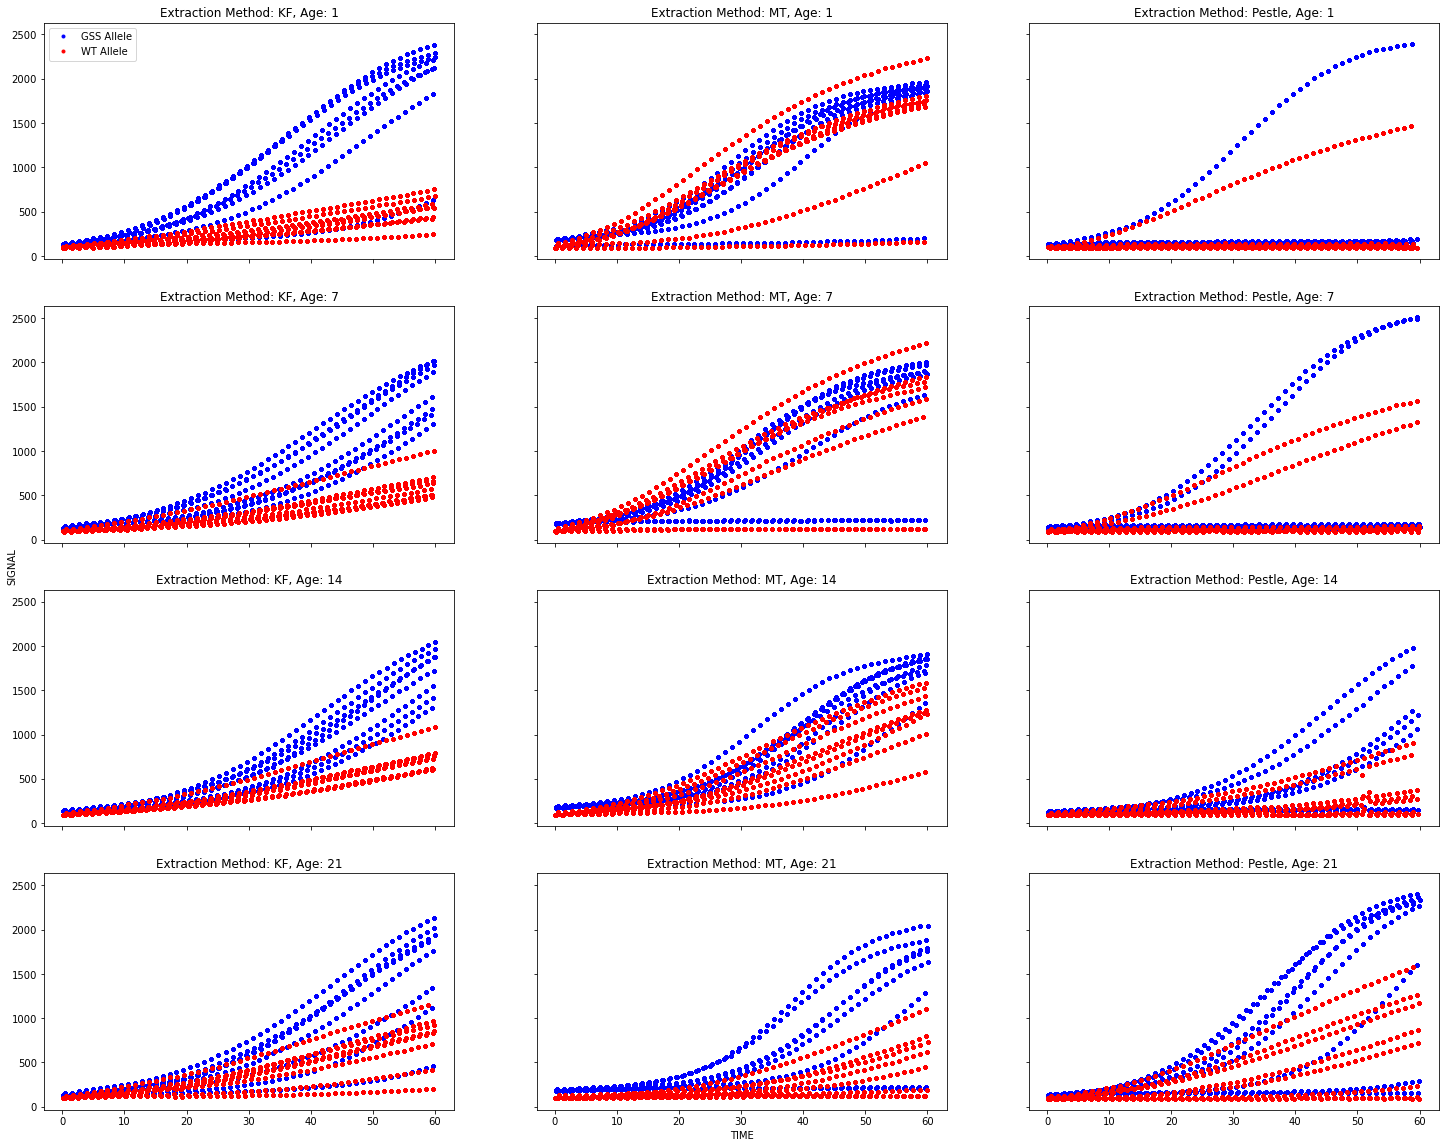

In [29]:
fig = plt.figure(figsize=(12,24))
fig, axs = plt.subplots(len(rowUniq), len(colUniq), figsize=(25,20), sharex='all', sharey='all')

#going through columns
for col in range(len(colUniq)):
    #going through rows
    for row in range(len(rowUniq)):
        #GSS allele
        GSSsub = assembledData.query("(`{0}` == '{1}') & (`{2}` == '{3}') & (CHANNEL == 3)"
                                     .format(colSub, colUniq[col], rowSub, rowUniq[row]))
        GSSxVal = GSSsub[x].tolist()
        GSSyVal = GSSsub[y].tolist()
        axs[row, col].plot(GSSxVal, GSSyVal, 'b.', label='GSS Allele')
        #WT Allele
        WTsub = assembledData.query("(`{0}` == '{1}') & (`{2}` == '{3}') & (CHANNEL == 2)"
                                     .format(colSub, colUniq[col], rowSub, rowUniq[row]))
        WTxVal = WTsub[x].tolist()
        WTyVal = WTsub[y].tolist()
        axs[row, col].plot(WTxVal, WTyVal, 'r.', label='WT Allele')
        axs[row, col].set_title('{0}: {1}, {2}: {3}'.format(colSub, colUniq[col], rowSub, rowUniq[row]))

        #adding labels to graph



axs[0, 0].legend(loc='upper left')
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("{0}".format(x))
plt.ylabel("{0}".format(y))

plt.savefig('MatMa_AgeSignal.png',format='png')

In [96]:
print(rowUniq)
try: 
    for i in range(len(rowUniq)):
        rowUniq[i] = int(rowUniq[i])
        
except ValueError:
    pass
rowUniq.sort()
print(rowUniq)

['1' '14' '21' '7']
[1 7 14 21]


In [ ]:
while True:
    try:
        output = int(input('Please type in the number of the data to {}:'.format(userPrompt)))
        if isinstance(output, int):
            #change to 0 count scale
            output = output - 1
            #there is a bug here. giving a 0 or negative number will rollover the list
            while len(options) <= output:
                output = int(input('Not a valid selection. Please type the number of the data to {}:'.format(userPrompt)))
            break
    except ValueError:
        print('Not a Number. Please type the Number of the data to {}:'.format(userPrompt))